# Hamiltonian Tomography

## Contents
* [Introduction](#introduction)
* [Fitting Functions](#fitting-functions)
* [Using the Pulse Simulator](#using-the-pulse-simulator)
* [Run Experiment on Backend Model Simulation](#run-experiment-model)
* [Fitting the Simulated Results](#fitting-the-simulated-results)
* [Measure ZI (Stark Shift) via CR Ramsey Experiment](#measure-zi-via-ramsey)
* [References](#references)


## Introduction <a class="anchor" id="introduction"></a>

The cross resonance gate for entangling qubits was introducted in [this section](https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html#6.-The-Cross-Resonance-Entangling-Gate-) of the Qiskit Textbook, where it is assumed the transmon is a qubit and the Schrieffer-Wolff transformation is applied to yield an effective Hamiltonian 

$$
\tilde{H}_{\rm eff}^{\rm CR} = - \frac{\Delta_{12}}{2}\sigma_1^z 
+ \frac{\Omega(t)}{2} \left(\sigma_2^x - \frac{J}{2\Delta_{12}} \sigma_1^z \sigma_2^x \right),
$$

where $\Delta_{12} = \tilde{\omega}_1-\tilde{\omega}_2$ is the difference between the dressed frequencies of the qubits, $\Omega$ is the cross resonance drive strength, and $J$ is the qubit-qubit coupling. We will use a common simplified notation for these interaction terms where the Pauli matrix is represented by a capital letter (with a hat to denote that it is an operator) and the qubit is represented by its position in a string, so for example we wish to isolate the $\hat{Z}\hat{X} = \hat{Z} \otimes \hat{X} = \sigma_1^z \otimes \sigma_2^x = \sigma_1^z \sigma_2^x$ interaction that is used to build the controlled-NOT gate from the $\hat{Z}\hat{I} = \sigma_1^z \otimes \sigma_2^0$ and $\hat{I}\hat{X} = \sigma_1^0 \otimes \sigma_2^x$ terms. Here the matrix $\sigma_i^0$ represents the identity matrix on qubit $i$. 

In addition to understanding these extra terms, since the [transmon](https://qiskit.org/textbook/ch-quantum-hardware/transmon-physics.html#4.-The-Quantized-Transmon-) has higher energy levels and actual experiments may have other interactions, due to crosstalk for example, when applying an entangling operation, it is not always obvious which Pauli rotations will be generated. Here we assume a cross resonance Hamiltonian of the [following form](https://arxiv.org/abs/1603.04821):

$$
\hat{H} = \frac{\hat{Z} \otimes \hat{A}}{2} + \frac{\hat{I} \otimes \hat{B}}{2} = 
a_{x} \hat{Z}\hat{X} + a_{y} \hat{Z}\hat{Y} + a_{z} \hat{Z}\hat{Z} + b_{x}  \hat{I}\hat{X} + b_{y} \hat{I}\hat{Y} + b_{z} \hat{I}\hat{Z}  
$$

where we will omit the Kronecker product symbol $\otimes$ for succinctness.  We refer to the first Pauli operator acting on the control qubit and second operators acting on the target qubits, as in the effective Hamiltonian above.  While the form of the cross resonance Hamiltonian is known, the individual coeficients $a_{\mu}, b_{\nu}$ are not known. Note that these coefficients are also referred to as the strengths of the interaction they correspond to, i.e. $a_x$ is the $ZX$ interaction rate, etc. We must then find a way of extracting the coefficients from measurements made on the system after the cross resonance pulse is applied for different durations. Before we proceed, it should be noted that cross resonance operation also generates a $\hat{Z}\hat{I}$ interaction arising from a Stark shift (off-resonant drive that dressed the qubit frequency). This term can be extracted by preforming a [Ramsey experiment](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#4.1-Measuring-the-qubit-Frequency-Precisely-using-a-Ramsey-Experiment-) on the control qubit. We will discuss this Ramsey procedure later on, so for know let us focus on the Hamiltonian that we wrote down.

The coefficients $a_{\mu}, b_{\nu}$ (interaction rates) will be extracted by taking six different measurements as a function of the duration of the pulse.  The six measurments are of the expectation value of each Pauli term on the target qubit with the control qubit either in the ground or excited state. In the next section we will show how these measurments give us information about the coefficients.

## Fitting Fuctions <a class="anchor" id="fitting-functions"></a>

In order to extract the coefficients $a_{\mu}, b_{\nu}$, we need to know what function we expect to fit to the measurement data.  The data we will be looking at will be the expectation value of Pauli operators as a function of pulse duration.  In the Heisenberg picture of quantum mechanics, the evolution of the expection value of an operator can be given as

$$\langle \hat{O}(t) \rangle = \langle e^{i\hat{H}t} \hat{O} e^{-i\hat{H}t} \rangle$$

Let $dt$ be an infinitesimally small time increment.  Then we have

$$\langle \hat{O}(t+dt) \rangle = \langle (1+i\hat{H} dt)\hat{O}(t)(1-i\hat{H} dt) \rangle = 
\langle \hat{O}(t) \rangle +i dt \langle \left[\hat{H},\hat{O}\right] \rangle
\Longrightarrow \frac{d\langle \hat{O} \rangle}{dt} = i \left[\hat{H},\hat{O}\right]$$

to first order in $dt$. We can evaluate the commutator for each of the Pauli operators:

\begin{equation}
\begin{split}
&\left[\hat{H}, \hat{I}\hat{X}\right] = 2 i \left(a_{y} \hat{Z}\hat{Z} - a_{z} \hat{Z}\hat{Y} + b_{y} \hat{I}\hat{Z} - b_{z} \hat{I}\hat{Y}\right) \\
&\left[\hat{H},\hat{I}\hat{Y}\right] = 2 i \left(-a_{x} \hat{Z}\hat{Z} + a_{z} \hat{Z}\hat{X} - b_{x} \hat{I}\hat{Z} + b_{z} \hat{I}\hat{X}\right)\\
&\left[\hat{H}, \hat{I}\hat{Z}\right] = 2 i \left(a_{x} \hat{Z}\hat{Y} - a_{y} \hat{Z}\hat{X} + b_{x} \hat{I}\hat{Y} - b_{y} \hat{I}\hat{X}\right)
\end{split}
\end{equation}

If we let $n$ be the expectation value of the Pauli $\hat{Z}$ operator on the control qubit, then we can write down these comutators in terms of the expectation values of the target qubit:

\begin{equation}
\begin{split}
&i\langle\left[\hat{H},\hat{I}\hat{X} \right]\rangle_{\rm control} = 2 \left(n a_{z} + b_{z}\right)\langle\hat{Y}\rangle - 2 \left(n a_{y} + b_{y}\right)\langle\hat{Z}\rangle
\\
&i\langle\left[\hat{H}, \hat{I}\hat{Y}\right]\rangle_{\rm control} = 2\left(n a_{x} + b_{x}\right) \langle\hat{Z}\rangle-2  \left(n a_{z} + b_{z}\right) \langle\hat{X}\rangle 
\\
&i\langle\left[\hat{H}, \hat{I}\hat{Z}\right]\rangle_{\rm control} = 2  \left(n a_{y} + b_{y}\right) \langle\hat{X}\rangle - 2 \left(n a_{x} + b_{x}\right) \langle\hat{Y}\rangle 
\end{split}
\end{equation}

where the expectation values on the right hand side are understood to be those of the target qubit, which will also be the case of the following discussion. Let us define $\vec{r}_n = \{\langle\hat{X}\rangle, \langle\hat{Y}\rangle, \langle\hat{Z}\rangle\}_n$ then we can use these commutators to write down a matrix equation for the time dependence of $\vec{r}$ depending on the Pauli-$Z$ value $n$ of the state of the control qubit. Then putting the above equations together

$$ \frac{d}{dt} \begin{bmatrix}
\langle \hat{X} \rangle \\ \langle \hat{Y} \rangle \\ \langle \hat{Z} \rangle \end{bmatrix} = 
2 \begin{bmatrix} 0 & na_z + b_z & -n a_y - b_y \\
-na_z - b_z & 0 & n a_x + b_x \\
na_y + b_y & -na_x - b_x & 0 \end{bmatrix} \begin{bmatrix}
\langle \hat{X} \rangle \\ \langle \hat{Y} \rangle \\ \langle \hat{Z} \rangle \end{bmatrix}
$$

or more compactly,

$$\frac{d\vec{r}_n(t)}{dt} = G_n \vec{r}_n(t),$$

where 

$$
G_n = 2 \begin{bmatrix} 0 & na_z + b_z & -n a_y - b_y \\
-na_z - b_z & 0 & n a_x + b_x \\
na_y + b_y & -na_x - b_x & 0 \end{bmatrix} \equiv \begin{bmatrix}0 & \Delta^n & -\Omega_y^n\\-\Delta^n & 0 & \Omega_x^n \\ \Omega_y^n & -\Omega_x^n & 0\end{bmatrix}.
$$

Since $G_n$ is time independent we can easily integrate the differential equation with the initial state corresponding to $t=0$, yielding

$$\vec{r}_n(t) = e^{G_n t} \vec{r}_n(0).$$

We can find the matrix exponential, $e^{G_n t}$, by finding the eigenvalues and eigenvectors of $G_n$.  The eigenvalues of $G_n$ are

$$
\vec{g}_{n} = \{0, -i\sqrt{\Delta^2+\Omega_x^2+\Omega_y^2} , i\sqrt{\Delta^2+\Omega_x^2+\Omega_y^2}\}_n,
$$

where for notationaly simplicity, the subscript $n$ denotes the appropriate values of $\Delta, \Omega_x, \Omega_y,$ given the state of the control qubit. We will not write down the eigenvectors because they are too cumbersome but it is straightforward to find them.  Let $U$ be the transformation into the eigenbasis and let $\hat{D}_n$ be the diagonal matrix of the eignvalues.  Then we can rewrite the time dependence of $\vec{r}_n(t)$ as

$$\vec{r}_n(t) = U^{\dagger} e^{\hat{D}_n t} U\vec{r}_n(0).$$

Setting ${\vec{r}_n(0) = \{0,0,1}\}$ (which corresponds the the target qubit starting in the $|0\rangle$ state) we have that

\begin{equation}
\begin{split}
&\langle \hat{X}(t) \rangle_n = \frac{1}{\Omega^2}\left(-\Delta \Omega_x + \Delta\Omega_x\cos(\Omega t) + \Omega \Omega_y \sin(\Omega t)\right)
\\
&\langle \hat{Y}(t) \rangle_n = \frac{1}{\Omega^2}\left(\Delta \Omega_y - \Delta\Omega_y\cos(\Omega t) - \Omega \Omega_x \sin(\Omega t)\right)
\\
&\langle \hat{Z}(t) \rangle_n = \frac{1}{\Omega^2}\left(\Delta^2 + \left(\Omega_x^2+\Omega_y^2\right)\cos(\Omega t) \right)
\end{split}
\end{equation}

where $\Omega = \sqrt{\Delta^2+\Omega_x^2+\Omega_y^2}$ for each control qubit preparation $n$. In the subsequent sections, we will often drop the hat (^) on the operators.

## Using the Pulse Simulator <a class="anchor" id="using-the-pulse-simulator"></a>

We will simulate on a model of a real device using the Pulse Simulator. First, load necessary libraries.

In [1]:
from qiskit import pulse
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit.test.mock import FakeAthens
style = SchedStyle(figsize=(20, 10))
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 15]
backend = FakeAthens()

Next, save the fake backend configuration and the sampling time $dt$. We will save the Hamiltonian parameters here for building a Duffing oscillator model later.

In [2]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


The `instruction_schedule_map` provides the parameters of the default calibrated pulses used by the backend. In particular, we see that this "native gate set" consists of a subset of operations you can perform on a [`QuantumCircuit`](https://qiskit.org/documentation/apidoc/circuit.html#gates-and-instructions), and is the gate set that the `QuantumCircuit` is transpiled to by Qiskit. 

In [3]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'u1', 'u2', 'u3', 'x']

Here we see the single-qubit ["U-gates"](https://qiskit.org/textbook/ch-states/single-qubit-gates.html#generalU3) `u1`, `u2`, and `u3`, controlled-NOT `cx`, identity `id`, measurement `measure` and $\pi$-pulse `x` for echoes. In particular, this is useful for retrieving pulses from the native gate set and manipulating them. For example, instead of building measurement pulses from scratch, we can retrieve it from the `instruction_schedule_map`.

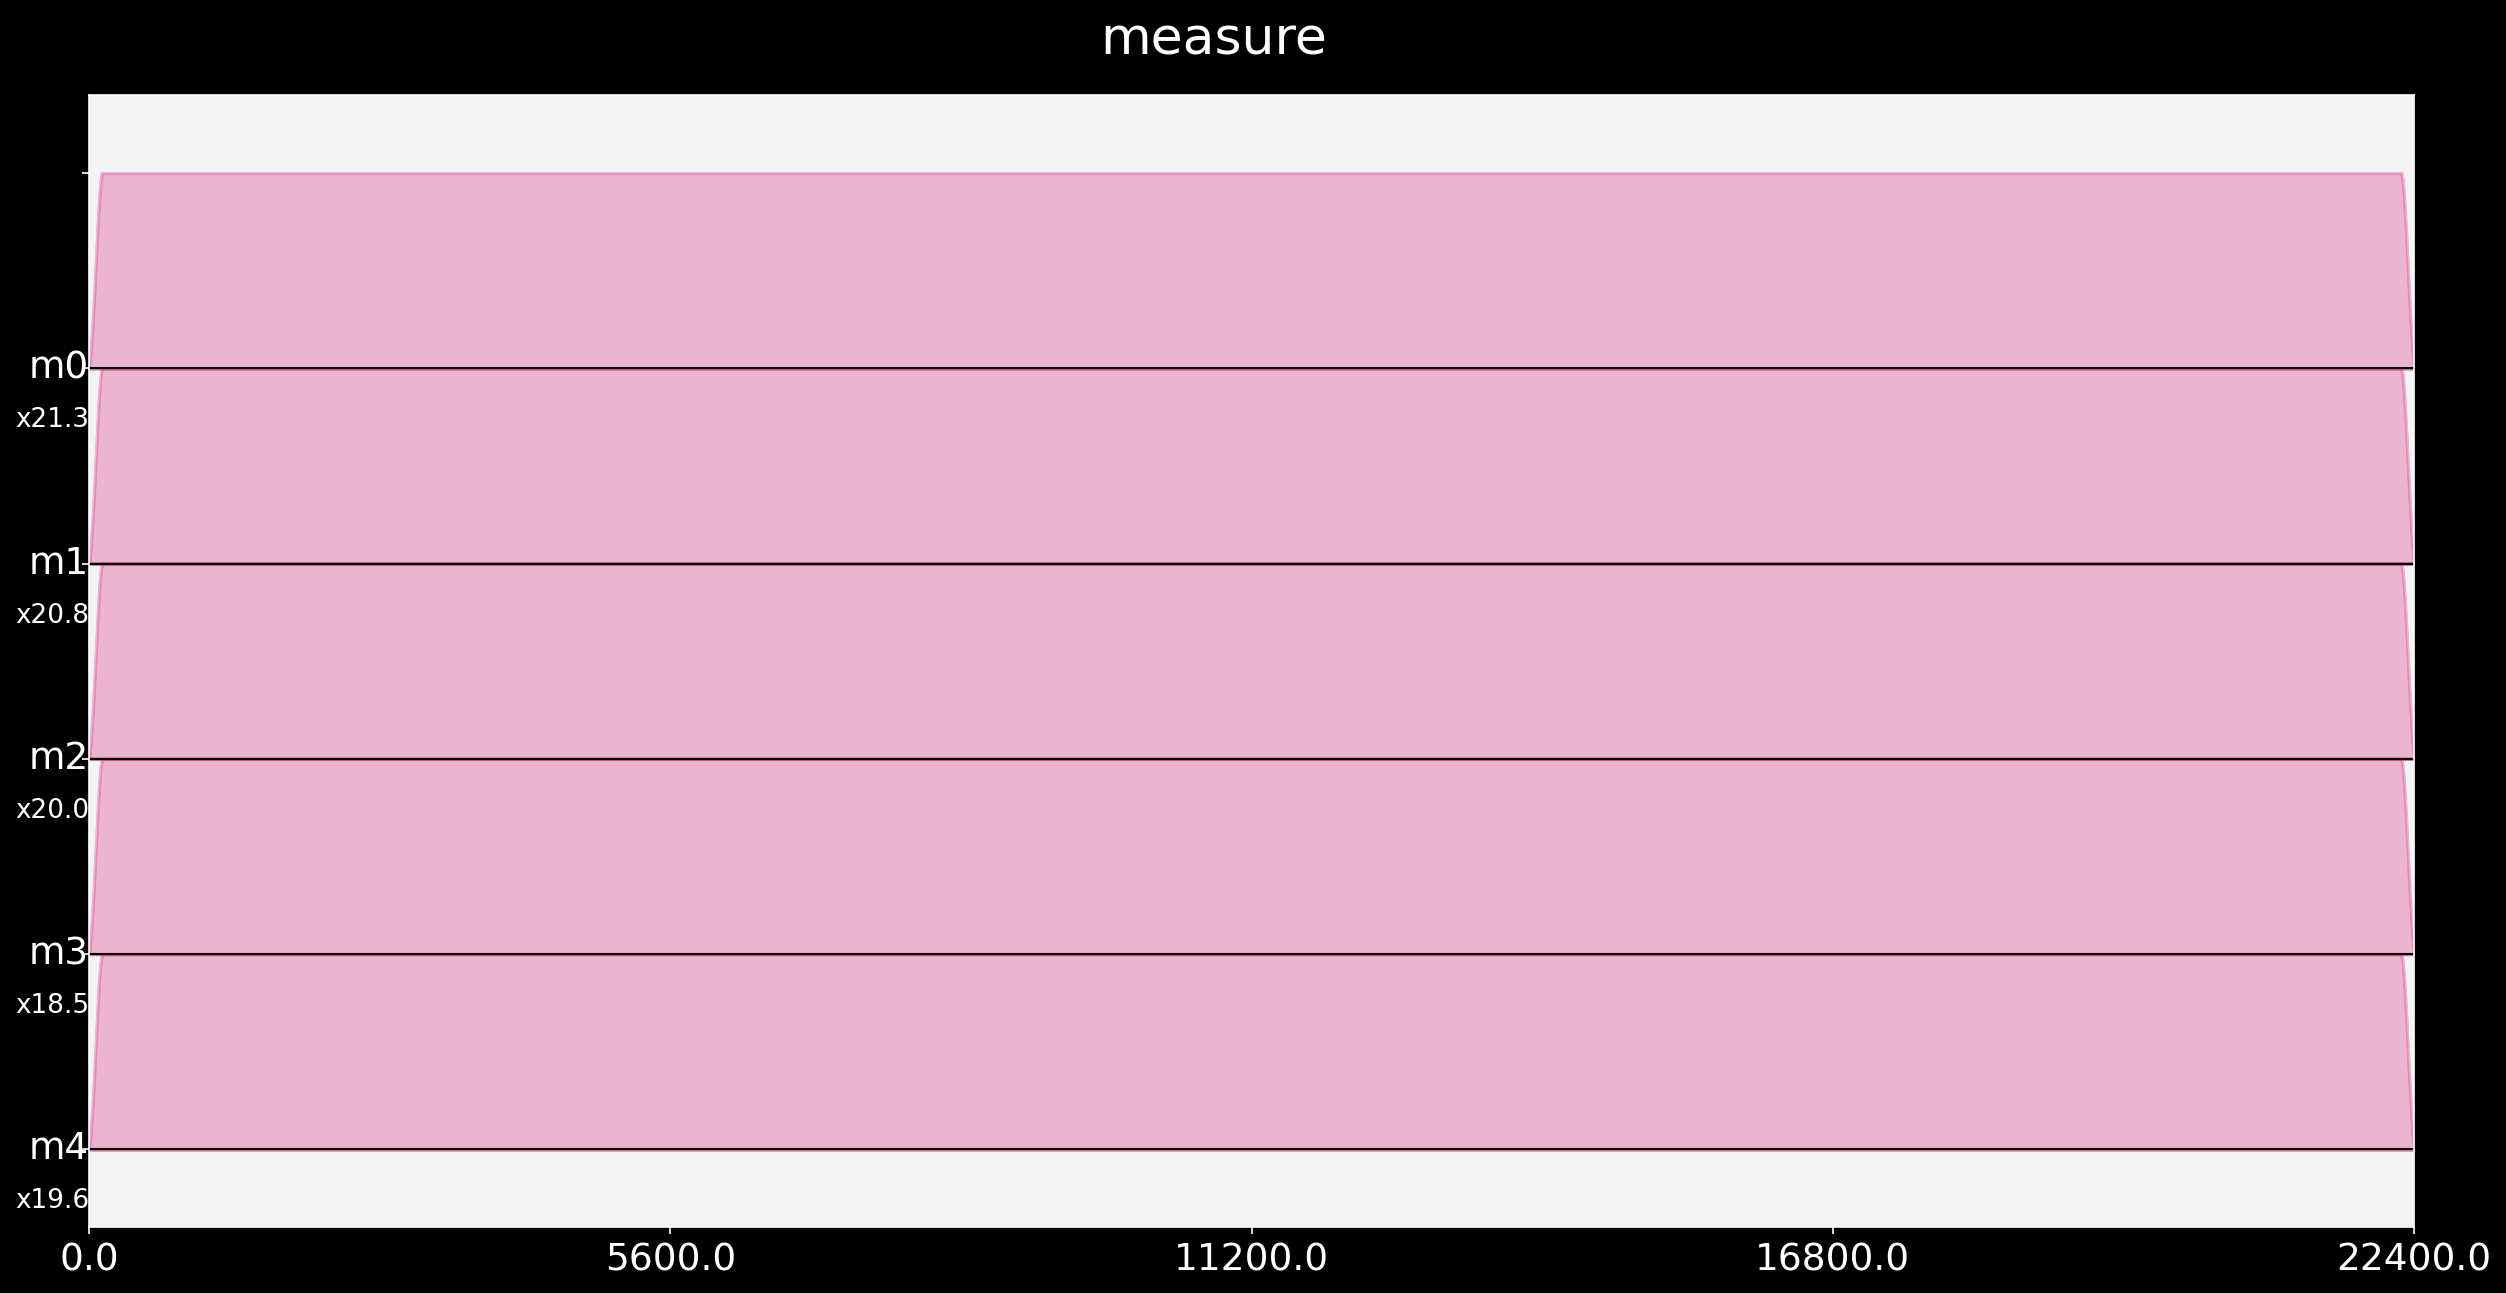

In [4]:
meas = inst_sched_map.get('measure', qubits=range(backend_config.n_qubits))
meas.exclude(channels=[pulse.AcquireChannel(i) 
                        for i in range(backend_config.n_qubits)]).draw(style=style)

For Hamiltonian tomography, we will also need the cross resonance pulse, which we can extract from the controlled-NOT.

In [5]:
def cx_pulse_instructions(qc: int, qt: int) -> Schedule:
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx
    
def get_cr_chan_inst(qc: int, qt: int) -> (ControlChannel, Waveform):
    """Retrieve the cross resonance pulse channel and waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    cx = cx_pulse_instructions(qc, qt)
    idx = 0
    # look for first Play instruction on a ControlChannel
    while (type(cx.instructions[idx][1].channels[0]) is not ControlChannel) or \
        (type(cx.instructions[idx][1]) is not Play):
        idx += 1
    return (cx.instructions[idx][1].channels[0], cx.instructions[idx][1].pulse)

Retrieve the cross resonance waveform and the control channel (`uchan`) it is played on.

In [6]:
uchan, cr_pulse = get_cr_chan_inst(1, 0)

Cross resonance pulses are of type [`GaussianSquare`](https://qiskit.org/documentation/stubs/qiskit.pulse.library.GaussianSquare.html), a square pulse with a Gaussian rise and fall. Currently the waveform samples are returned from the `instruction_schedule_map`, so we must elucidate the `GaussianSquare` parameters so we can easily build our own cross resonance pulses. In particular, we wish to find the amplitude because it is typically calibrated to be the largest amplitude that does not result in leakage to the higher order so that the shortest gate length can be achieved.

In [7]:
# middle sample will contain the amplitude
cr_amp = cr_pulse.samples[len(cr_pulse.samples)//2]
cr_dur = cr_pulse.duration
cr_risefall = 128 # guess
cr_width = cr_dur - 2*cr_risefall
my_cr_pulse = GaussianSquare(duration=cr_dur, amp=cr_amp, sigma=cr_risefall//2, width=cr_width)

Let's build a test schedule to visualize the default cross resonance pulse against the one we just constructed.

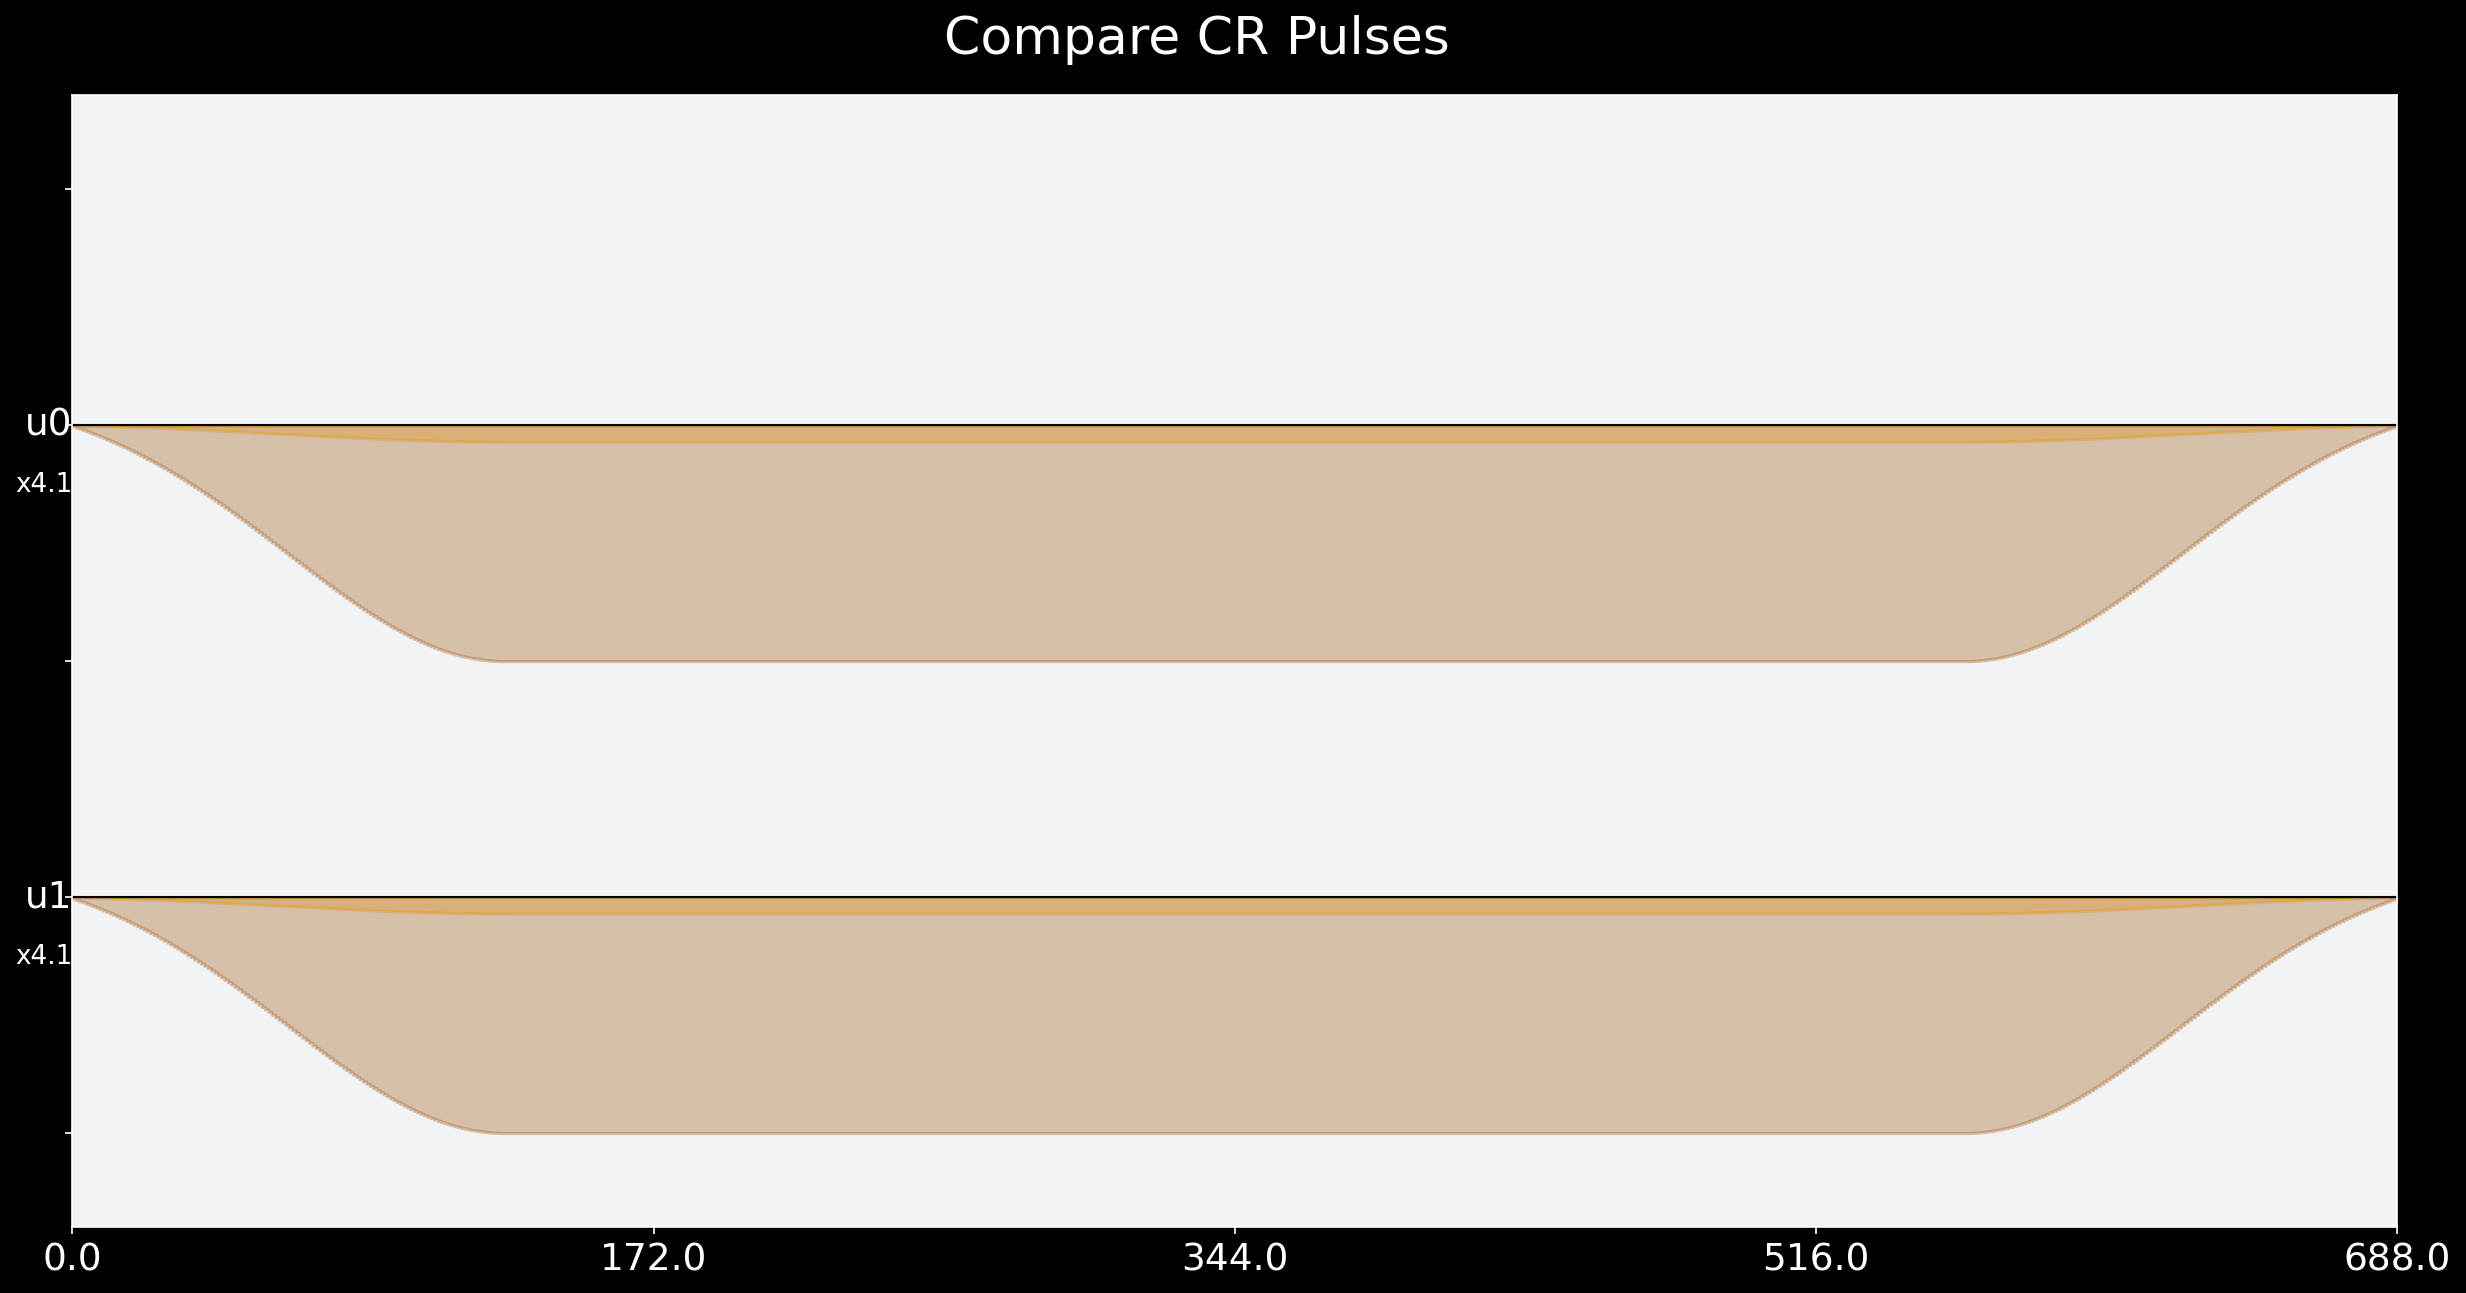

In [8]:
with pulse.build(name="Compare CR Pulses") as cr_test_sched:
    pulse.play(cr_pulse, ControlChannel(0))
    pulse.play(my_cr_pulse, ControlChannel(1))

cr_test_sched.draw(style=style)

Pretty good! This will be close enough for the Hamiltonian tomography experiment. Now, this pulse nominally executes $ZX(\theta=\pi/4)$ corresponding to the [RZXGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZXGate.html) because the cross resonance pulse is echoed: the first half will be a positive rotation dependent on the state of the control qubit, followed by an "echo pulse" that flips the control qubit, followed by a negative rotation dependent on the new state of the control qubit. This turns out to be equivalent to a $ZX(\theta=\pi/2)$, but we are just dealing with the first part of the pulse so that we can observe the full effect of the cross resonance interaction. We keep this in mind because this particular `cr_dur` will only take us an angle of $\theta=\pi/4$ around the Bloch sphere, and for the Hamiltonian tomography experiment we wish to traverse the Bloch sphere several times.

In [9]:
def build_cr_pulse(qc: int, qt: int, width: int, control='0', 
                   basis='Z', phase=0.0, framechange=0.0) -> Schedule:
    """Build a cross resonance pulse schedule for a given set of parameters.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      width: width of cross resonance pulse (in dt)
      control: control qubit prepared as '0' or '1'
      basis: measurement basis of target qubit
      phase: phase offset of cross resonance pulse (rad)
      framechange: compensated Z-rotation on control performed in software (rad)
    """
    with pulse.build() as sched:
        with pulse.align_sequential():
            if control == '1':
                Xp = inst_sched_map.get('x', qubits=[qc])
                pulse.call(Xp) # flip control from |0> to |1>
            
            duration = width + 2*cr_risefall
            with pulse.phase_offset(phase, uchan):
                pulse.play(GaussianSquare(duration=duration, amp=cr_amp, sigma=cr_risefall//2, width=width), uchan)
            pulse.shift_phase(framechange, DriveChannel(qc))
            
            # rotate target for appropriate Pauli measurement
            if basis == 'X':
                Y90m = inst_sched_map.get('u2', P0=np.pi, P1=np.pi, qubits=[qt])
                pulse.call(Y90m)
            elif basis == 'Y':
                X90p = inst_sched_map.get('u2', P0=-np.pi/2, P1=np.pi/2, qubits=[qt])
                pulse.call(X90p)
            
            return sched

def build_cr_scheds(qc: int, qt: int, cr_times, phase=0.0, ZI_MHz=0.0) -> np.array:
    """Build an array of cross resonance schedules for the
    Hamiltonian tomography experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_times: array of widths of the cross resonance pulses
      phase: phase offset of the cross resonance pulse (rad)
      ZI_MHz: ZI interaction rate (in MHz) to correct for with frame change
    """
    scheds = []
    for width in cr_times:
        framechange = 2*np.pi*int(width)*dt*ZI_MHz*1e6
        for basis in ['X', 'Y', 'Z']:
            for control in ['0', '1']:
                with pulse.build(name="CR width %i" %width) as sched:
                    with pulse.align_sequential():
                        pulse.call(build_cr_pulse(qc, qt, int(width), control=control, \
                                                  basis=basis, phase=phase, framechange=framechange))
                        pulse.call(meas)
                scheds.append(sched)
    return scheds

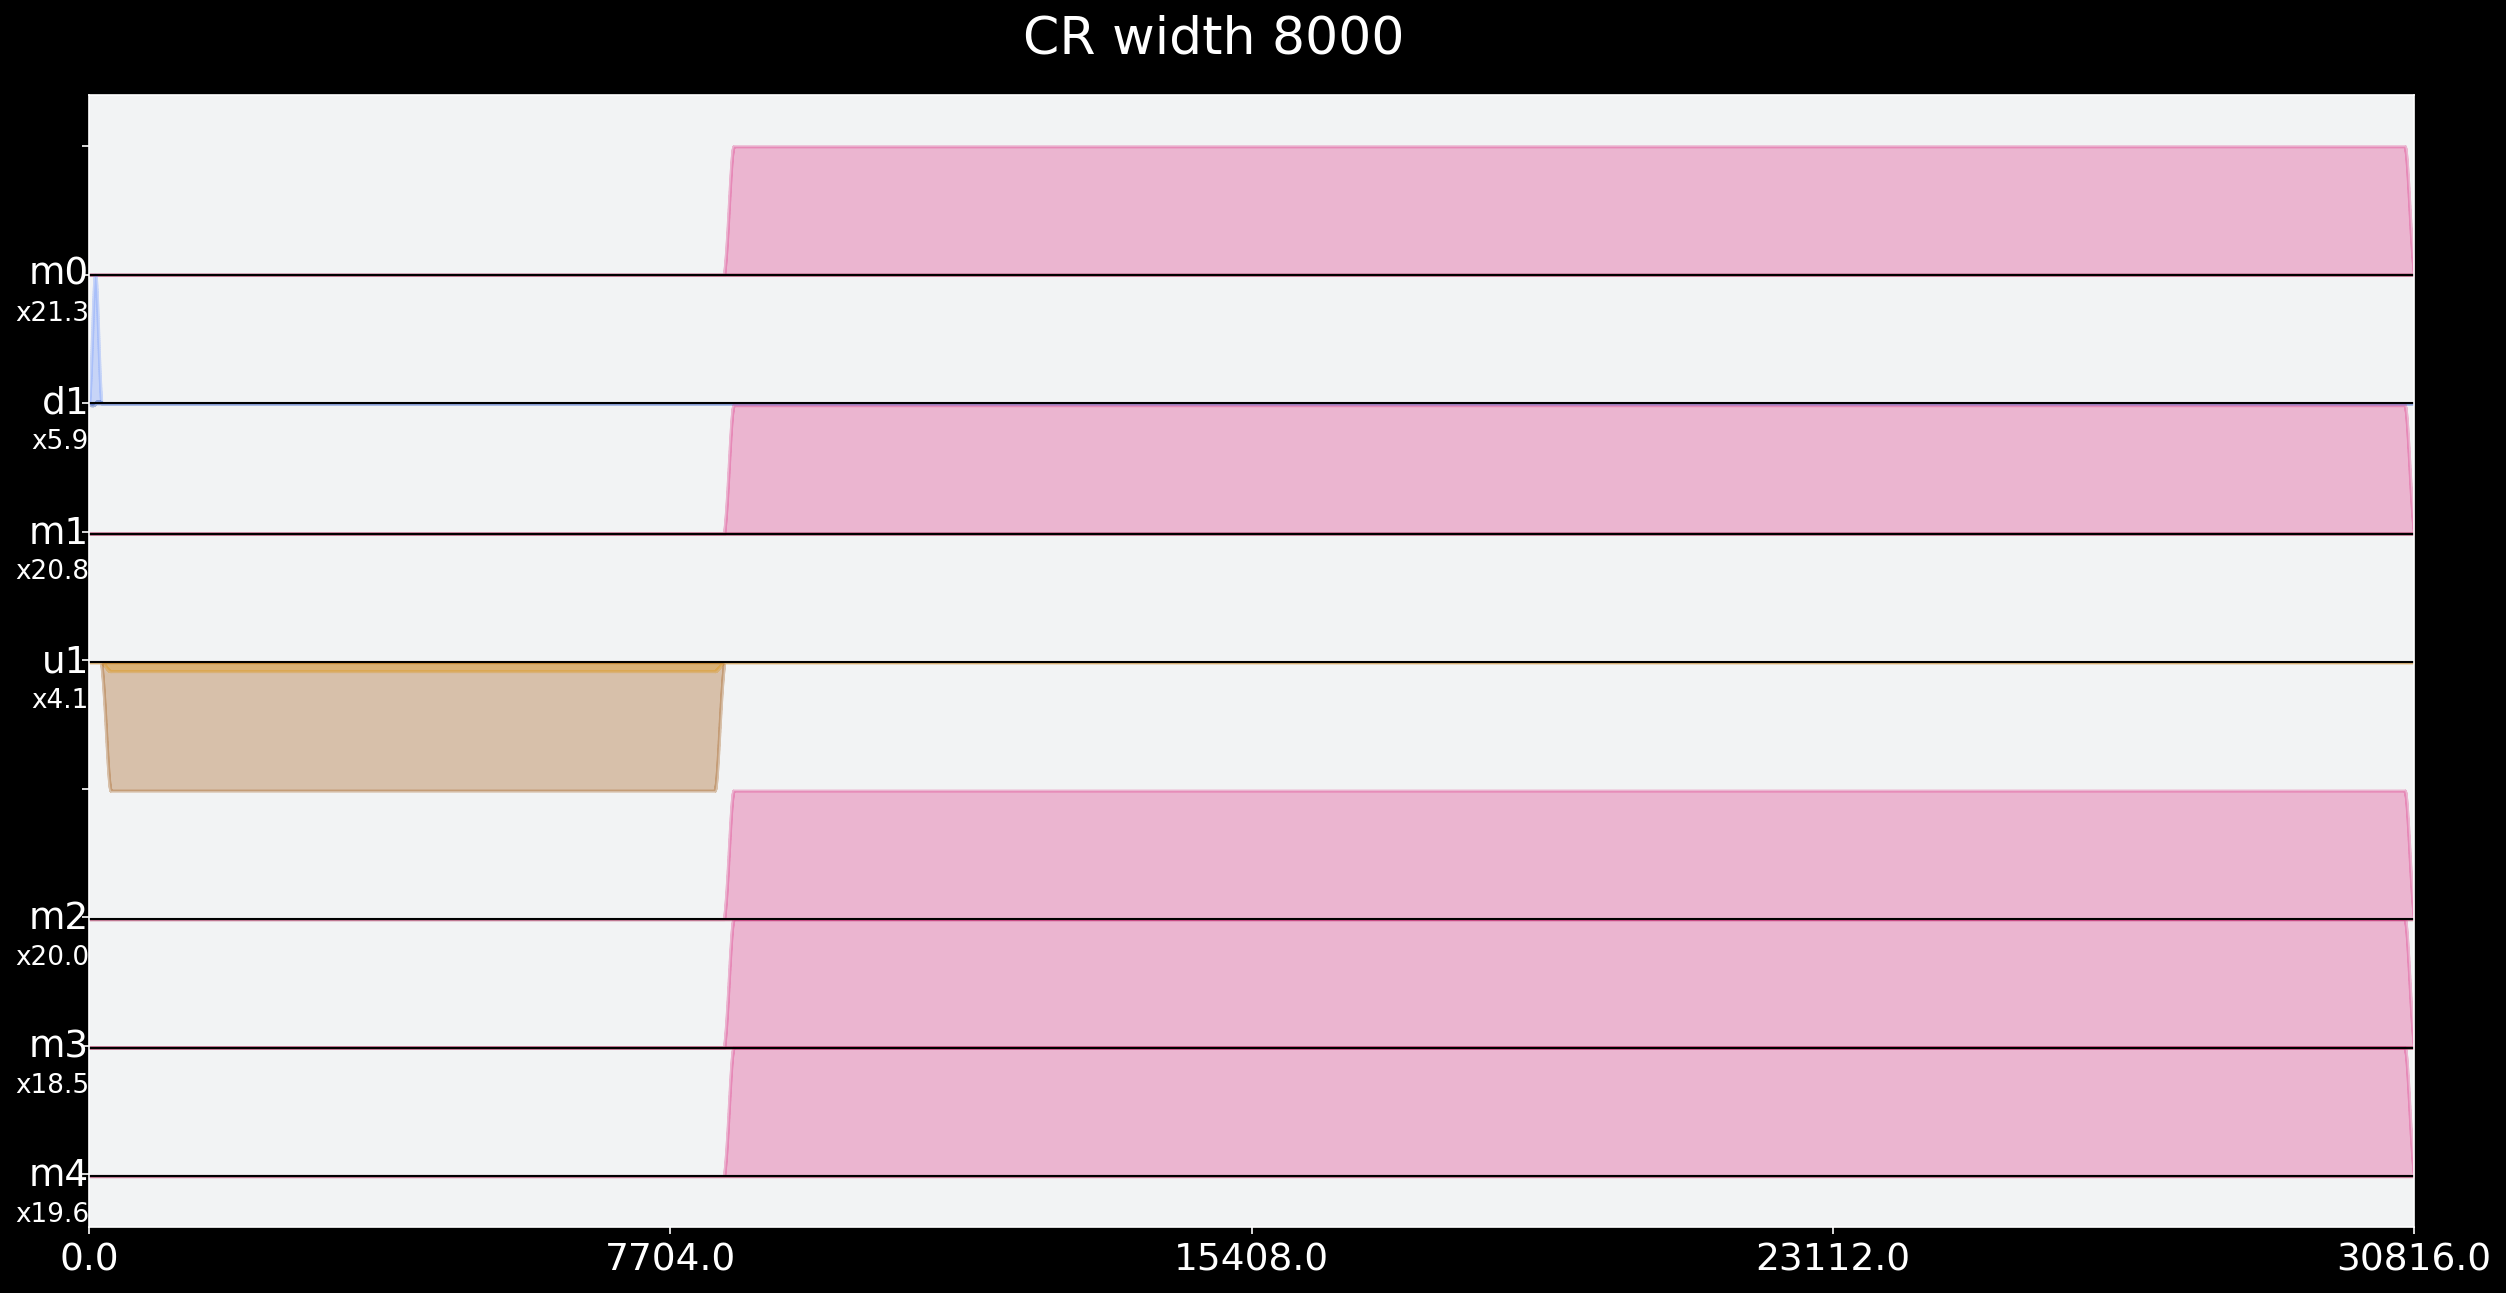

In [10]:
qt = 0
qc = 1

# remember samples must be in multiples of 16
cr_times = 16*np.linspace(0, 500, 21)
cr_scheds = build_cr_scheds(qc, qt, cr_times)
cr_scheds[-1].exclude(channels=[pulse.AcquireChannel(i) 
                        for i in range(backend_config.n_qubits)]).draw(style=style)

Note how the final schedule consists of the control in the $|1\rangle$ state due to the $\pi$-pulse on `d1` channel before the cross resonance pulse and this is measured in the $Z$-basis because there is no subsequent pulse on the `d0` channel.

## Run Experiment on Backend Model Simulation  <a class="anchor" id="run-experiment-model"></a>

We will construct a [Duffing oscillator](https://qiskit.org/textbook/ch-quantum-hardware/transmon-physics.html#4.-The-Quantized-Transmon-) model based on the Hamiltonian model of `ibmq_athens`. Then we collect the relevant Hamiltonian parameters from the `params` extracted from the backend configuration and create the model from them. 

In [11]:
from qiskit.providers.aer.pulse import duffing_system_model

dim_oscillators = 3 # cutoff Hilbert space dimension per transmon

SF = 1/(2*np.pi) # scale factor to convert from angular frequency to Hz

oscillator_freqs = [] # qubit transition frequencies
anharm_freqs = [] # qubit anharmonicities
drive_strengths = [] # drive Rabi strength
coupling_dict = {} # coupling strength between qubit pairs

for key in ham_params:
    if 'wq' in key:
        oscillator_freqs.append(ham_params[key]*SF)
    elif 'delta' in key:
        anharm_freqs.append(ham_params[key]*SF)
    elif 'omegad' in key:
        drive_strengths.append(ham_params[key]*SF)
    elif 'jq' in key:
        _, q0str, q1str = key.split('q')
        q0idx = int(q0str)
        q1idx = int(q1str)
        coupling_dict[(q0idx, q1idx)] = ham_params[key]*SF
        
# create the model
backend_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

In [12]:
from qiskit import assemble
from qiskit.providers.aer import PulseSimulator
backend_sim = PulseSimulator()
qubit_lo_freq = backend_model.hamiltonian.get_qubit_lo_from_drift()

In [13]:
def run_pulse(sched): 
    """Runs the scheduled experiment on the simulated backend.
    
    Args:
      sched: pulse schedule to run
    """
    # assemble the qobj
    test_qobj = assemble(sched,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=5012)
    
    # run simulation
    sim_result = backend_sim.run(test_qobj, system_model=backend_model).result()
    
    return sim_result.get_memory(0)

def run_ham_tomo(cr_times, cr_scheds):
    """Run Hamiltonian tomography experiment and return results.
    
    Args:
      cr_times: widths of cross resonance pulses
      cr_scheds: array of pulse schedules for Ham Tomo experiment
    """
    # expectation values of target conditioned on control
    avg_t_c = np.zeros((6, len(cr_times)), dtype=complex)

    # sanity check: expectation values of control conditioned on control
    avg_c_c = np.zeros((6, len(cr_times)), dtype=complex)

    for ii in range(len(cr_scheds)):
        #if ii % 6 == 0:
        #    print(str(int(ii//6))+': Performing simulations for CR tone width of '+str(int(cr_times[ii//6]*dt*1e9))+' ns!')
        result = run_pulse(cr_scheds[ii])
        avg_t_c[ii % 6, ii // 6] = 1 - 2*result[qt]
        avg_c_c[ii % 6, ii // 6] = result[qc]
        
    return np.real(avg_t_c), np.real(avg_c_c)

#### **Warning!** The Pulse Simulator is computationally intensive and each experiment consisting of runs of 21 schedules and 5012 shots may take tens of minutes up to hours depending on CPU performance. The schedules with longer cross resonance pulses are more computationally intensive than those with shorter ones.

In [14]:
avg_t_c, avg_c_c = run_ham_tomo(cr_times, cr_scheds)

## Fitting the Simulated Results <a class="anchor" id="fitting-the-simulated-results"></a>

Using the `scipy` package, the fitting functions below will fit the Hamiltonian tomography data, Pauli expectations of the target qubit $\langle X(t) \rangle, \langle Y(t) \rangle, \langle Z(t) \rangle$, for the control prepared in either the ground or excited state. Note that we must use a trick to concatenate all the data into a single array by `tile`ing the time array and `vstack`ing the data so we can use the `curve_fit` function.

In [15]:
from scipy.optimize import curve_fit

def get_omega(eDelta, eOmega_x, eOmega_y):
    """Return \Omega from parameter arguments."""
    eOmega = np.sqrt(eDelta**2 + eOmega_x**2 + eOmega_y**2)
    return eOmega

def avg_X(t, eDelta, eOmega_x, eOmega_y):
    """Return average X Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eXt = (-eDelta*eOmega_x + eDelta*eOmega_x*np.cos(eOmega*t) + \
           eOmega*eOmega_y*np.sin(eOmega*t)) / eOmega**2
    return eXt

def avg_Y(t, eDelta, eOmega_x, eOmega_y):
    """Return average Y Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eYt = (eDelta*eOmega_y - eDelta*eOmega_y*np.cos(eOmega*t) - \
           eOmega*eOmega_x*np.sin(eOmega*t)) / eOmega**2
    return eYt

def avg_Z(t, eDelta, eOmega_x, eOmega_y):
    """Return average Z Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eZt = (eDelta**2 + (eOmega_x**2 + eOmega_y**2)*np.cos(eOmega*t)) / eOmega**2
    return eZt

def rt_evol(ts, eDelta, eOmega_x, eOmega_y):
    """Stack average X,Y,Z Pauli measurements vertically."""
    return np.vstack([avg_X(ts, eDelta, eOmega_x, eOmega_y), \
                     avg_Y(ts, eDelta, eOmega_x, eOmega_y), \
                     avg_Z(ts, eDelta, eOmega_x, eOmega_y)])
    
def rt_flat(ts, eDelta, eOmega_x, eOmega_y):
    """Flatten X,Y,Z Pauli measurement data into 1D array."""
    return rt_evol(ts[0:len(ts)//3], eDelta, eOmega_x, eOmega_y).flatten()

def fit_rt_evol(ts, eXt, eYt, eZt, p0):
    """Use curve_fit to determine fit parameters of X,Y,Z Pauli measurements together."""
    rt_vec = np.asarray([eXt, eYt, eZt])
    return curve_fit(rt_flat, np.tile(ts, 3), rt_vec.flatten(), p0=p0)

### Plotting Functions

The above fits provide the parameters $\Omega^i_x, \Omega^i_y$, and $\Delta^i$ for the control qubit prepared in states $i = |0\rangle, |1\rangle$ (corresponding to $n=\pm 1$ in the equations above). The interaction rates (coefficients $a_\mu, b_\nu$ of the operators) are then determined as 

$$
IX = \frac{1}{2} \left( \Omega^0_x + \Omega^1_x\right) \qquad ZX = \frac{1}{2} \left( \Omega^0_x - \Omega^1_x\right) \\
IY = \frac{1}{2} \left( \Omega^0_y + \Omega^1_y\right) \qquad ZY = \frac{1}{2} \left( \Omega^0_y - \Omega^1_y\right) \\
IZ = \frac{1}{2} \left( \Delta^0 + \Delta^1\right) \qquad ZZ = \frac{1}{2} \left( \Delta^0 - \Delta^1\right)
$$

In [16]:
def get_interation_rates_MHz(ground_fit, excited_fit):
    """Determine interaction rates from fits to ground and excited control qubit data."""
    Delta0 = (ground_fit[0]/dt)/1e6
    Omega0_x = (ground_fit[1]/dt)/1e6
    Omega0_y = (ground_fit[2]/dt)/1e6
    Delta1 = (excited_fit[0]/dt)/1e6
    Omega1_x = (excited_fit[1]/dt)/1e6
    Omega1_y = (excited_fit[2]/dt)/1e6
    
    IX = 0.5*(Omega0_x + Omega1_x)
    IY = 0.5*(Omega0_y + Omega1_y)
    IZ = 0.5*(Delta0 + Delta1)
    ZX = 0.5*(Omega0_x - Omega1_x)
    ZY = 0.5*(Omega0_y - Omega1_y)
    ZZ = 0.5*(Delta0 - Delta1)
    
    return [[IX, IY, IZ], [ZX, ZY, ZZ]]

def plot_cr_ham_tomo(cr_times, avg_t_c, avg_c_c, ground_fit, excited_fit):
    """Plot Hamiltonian tomography data and curve fits with interaction rates."""
    coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
    ax1.scatter(cr_times, avg_t_c[0,:].real, lw=3.0, color='blue', label='ctrl in |0>')
    ax1.plot(cr_times, avg_X(cr_times, *ground_fit), lw=3.0, color='blue')
    ax1.scatter(cr_times, avg_t_c[1,:].real, lw=3.0, color='red', label='ctrl in |1>')
    ax1.plot(cr_times, avg_X(cr_times, *excited_fit), lw=3.0, color='red')
    ax1.set_ylabel('<X(t)>', fontsize=20)
    ax1.set_title('Pauli Expectation Value', fontsize=20)
    ax1.legend(loc=4, fontsize=14)
    ax2.scatter(cr_times, avg_t_c[2,:].real, lw=3.0, color='blue', label='ctrl in |0>')
    ax2.plot(cr_times, avg_Y(cr_times, *ground_fit), lw=3.0, color='blue')
    ax2.scatter(cr_times, avg_t_c[3,:].real, lw=3.0, color='red', label='ctrl in |1>')
    ax2.plot(cr_times, avg_Y(cr_times, *excited_fit), lw=3.0, color='red')
    ax2.set_title('IX = %.3f MHz   IY = %.3f MHz   IZ = %.3f MHz' % \
              (coeffs[0][0], coeffs[0][1], coeffs[0][2]), fontsize=20)
    ax2.set_ylabel('<Y(t)>', fontsize=20)
    ax2.legend(loc=4, fontsize=14)
    ax3.scatter(cr_times, avg_t_c[4,:].real, lw=3.0, color='blue', label='ctrl in |0>')
    ax3.plot(cr_times, avg_Z(cr_times, *ground_fit), lw=3.0, color='blue')
    ax3.scatter(cr_times, avg_t_c[5,:].real, lw=3.0, color='red', label='ctrl in |1>')
    ax3.plot(cr_times, avg_Z(cr_times, *excited_fit), lw=3.0, color='red')
    ax3.set_title('ZX = %.3f MHz   ZY = %.3f MHz   ZZ = %.3f MHz' % \
              (coeffs[1][0], coeffs[1][1], coeffs[1][2]), fontsize=20)
    ax3.set_ylabel('<Z(t)>', fontsize=20)
    ax3.set_xlabel('time (dt)', fontsize=20)
    ax3.legend(loc=4, fontsize=14)

### Fit and Plot

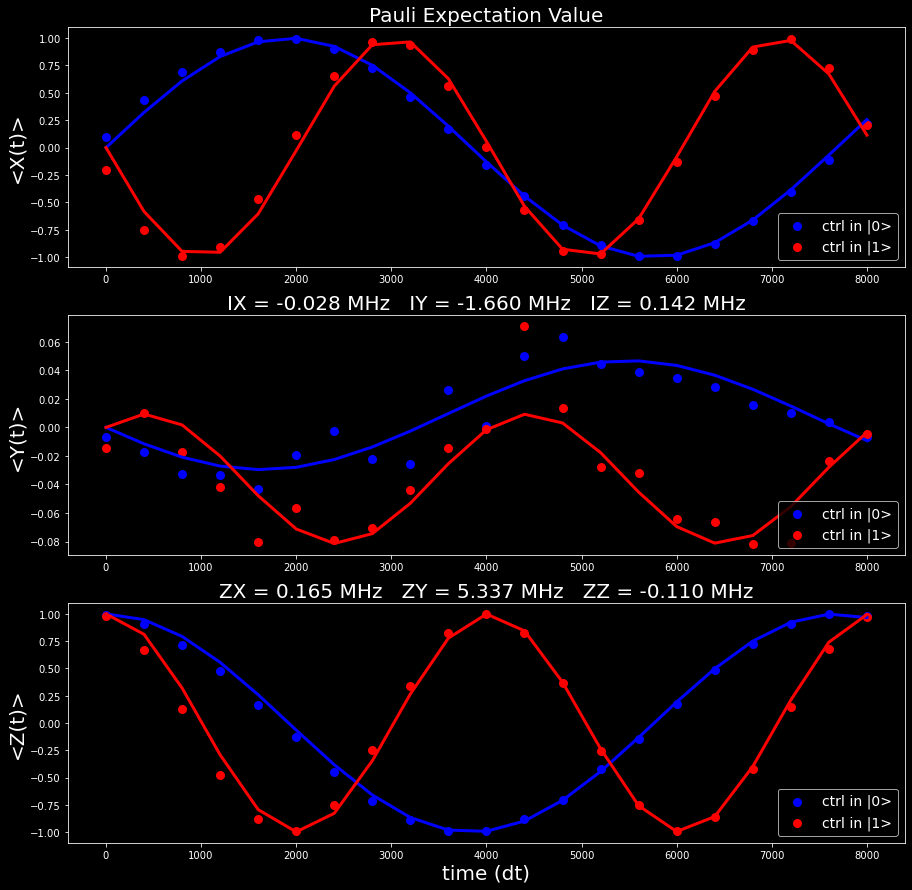

In [17]:
ground_fit,_ = fit_rt_evol(cr_times, avg_t_c[0,:], avg_t_c[2,:], avg_t_c[4,:], p0=[0.0002, 0.0002, 0.0005])
excited_fit,_ = fit_rt_evol(cr_times, avg_t_c[1,:], avg_t_c[3,:], avg_t_c[5,:], p0=[0.0002, 0.001, 0.001])

plot_cr_ham_tomo(cr_times, avg_t_c, avg_c_c, ground_fit, excited_fit)

Note here that the magnitude of the $ZY$ interaction is a lot larger than the desired $ZX$ interaction. This is because the cross resonance pulse is out of phase with the single-qubit drive $IX$ on the target qubit (not the $IX$ here induced by the cross resonance pulse). We can determine this from the interaction rates and shift the phase of the cross resonance pulse in the next Hamiltonian tomography experiment.

In [18]:
coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
ZX_rate = coeffs[1][0]
ZY_rate = coeffs[1][1]
phase = -np.arctan2(ZY_rate, ZX_rate)
print('Phase from ZY/ZX ratio is '+str(phase))

Phase from ZY/ZX ratio is -1.5398023429098322


In [19]:
cr_scheds = build_cr_scheds(qc, qt, cr_times, phase=phase)
avg_t_c, avg_c_c = run_ham_tomo(cr_times, cr_scheds)

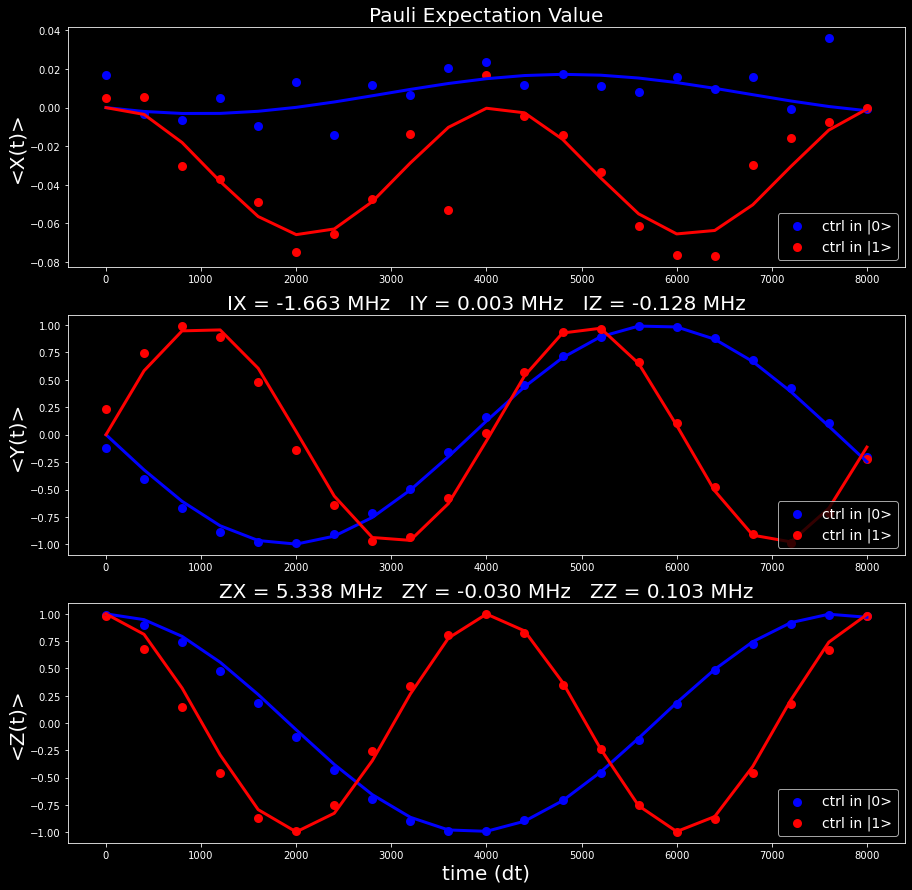

In [20]:
ground_fit,_ = fit_rt_evol(cr_times, avg_t_c[0,:], avg_t_c[2,:], avg_t_c[4,:], p0=[0.0002, 0.0002, 0.0005])
excited_fit,_ = fit_rt_evol(cr_times, avg_t_c[1,:], avg_t_c[3,:], avg_t_c[5,:], p0=[0.0002, 0.001, 0.001])

plot_cr_ham_tomo(cr_times, avg_t_c, avg_c_c, ground_fit, excited_fit)

Now we can see that the bulk of the cross resonance pulse provides the $ZX$-interaction that we can use to entangle qubits.

## Measure ZI (Stark Shift) via CR Ramsey Experiment <a class="anchor" id="measure-zi-via-ramsey"></a>

Here we measure the $ZI$ interaction term via a [Ramsey experiment](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#4.1-Measuring-the-qubit-Frequency-Precisely-using-a-Ramsey-Experiment-), recalling that the resulting oscillation are a result of the difference between the qubit and drive frequency. Since the frequency (Stark) shift and $ZI$ interaction are equivalent because a frequency shift induces a $Z$-rotation on the control qubit, we can measure this shift and compensate for it with a [frame change](https://arxiv.org/abs/1612.00858).

In [21]:
def build_cr_ramsey_scheds(qc: int, qt: int, cr_times, phase=0.0, ZI_MHz=0.0) -> np.array:
    """Build array of pulse schedules for CR Ramsey experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_times: width of cross resonance pulses (in dt)
      phase: phase offset of cross resonance pulse (rad)
      ZI_MHz: Z-rotation rate of control qubit (in MHz) compensated in software by frame change
    """
    X90p = inst_sched_map.get('u2', P0=-np.pi/2, P1=np.pi/2, qubits=[qc])
    scheds = []
    for width in cr_times:
        with pulse.build() as sched:
            with pulse.align_sequential():
                pulse.call(X90p)
                framechange = 2*np.pi*int(width)*dt*ZI_MHz*1e6
                pulse.call(build_cr_pulse(qc, qt, int(width), control='0', \
                                            basis='Z', phase=phase, framechange=framechange))
                pulse.call(X90p)
                pulse.call(meas)
                
        scheds.append(sched)
    return scheds

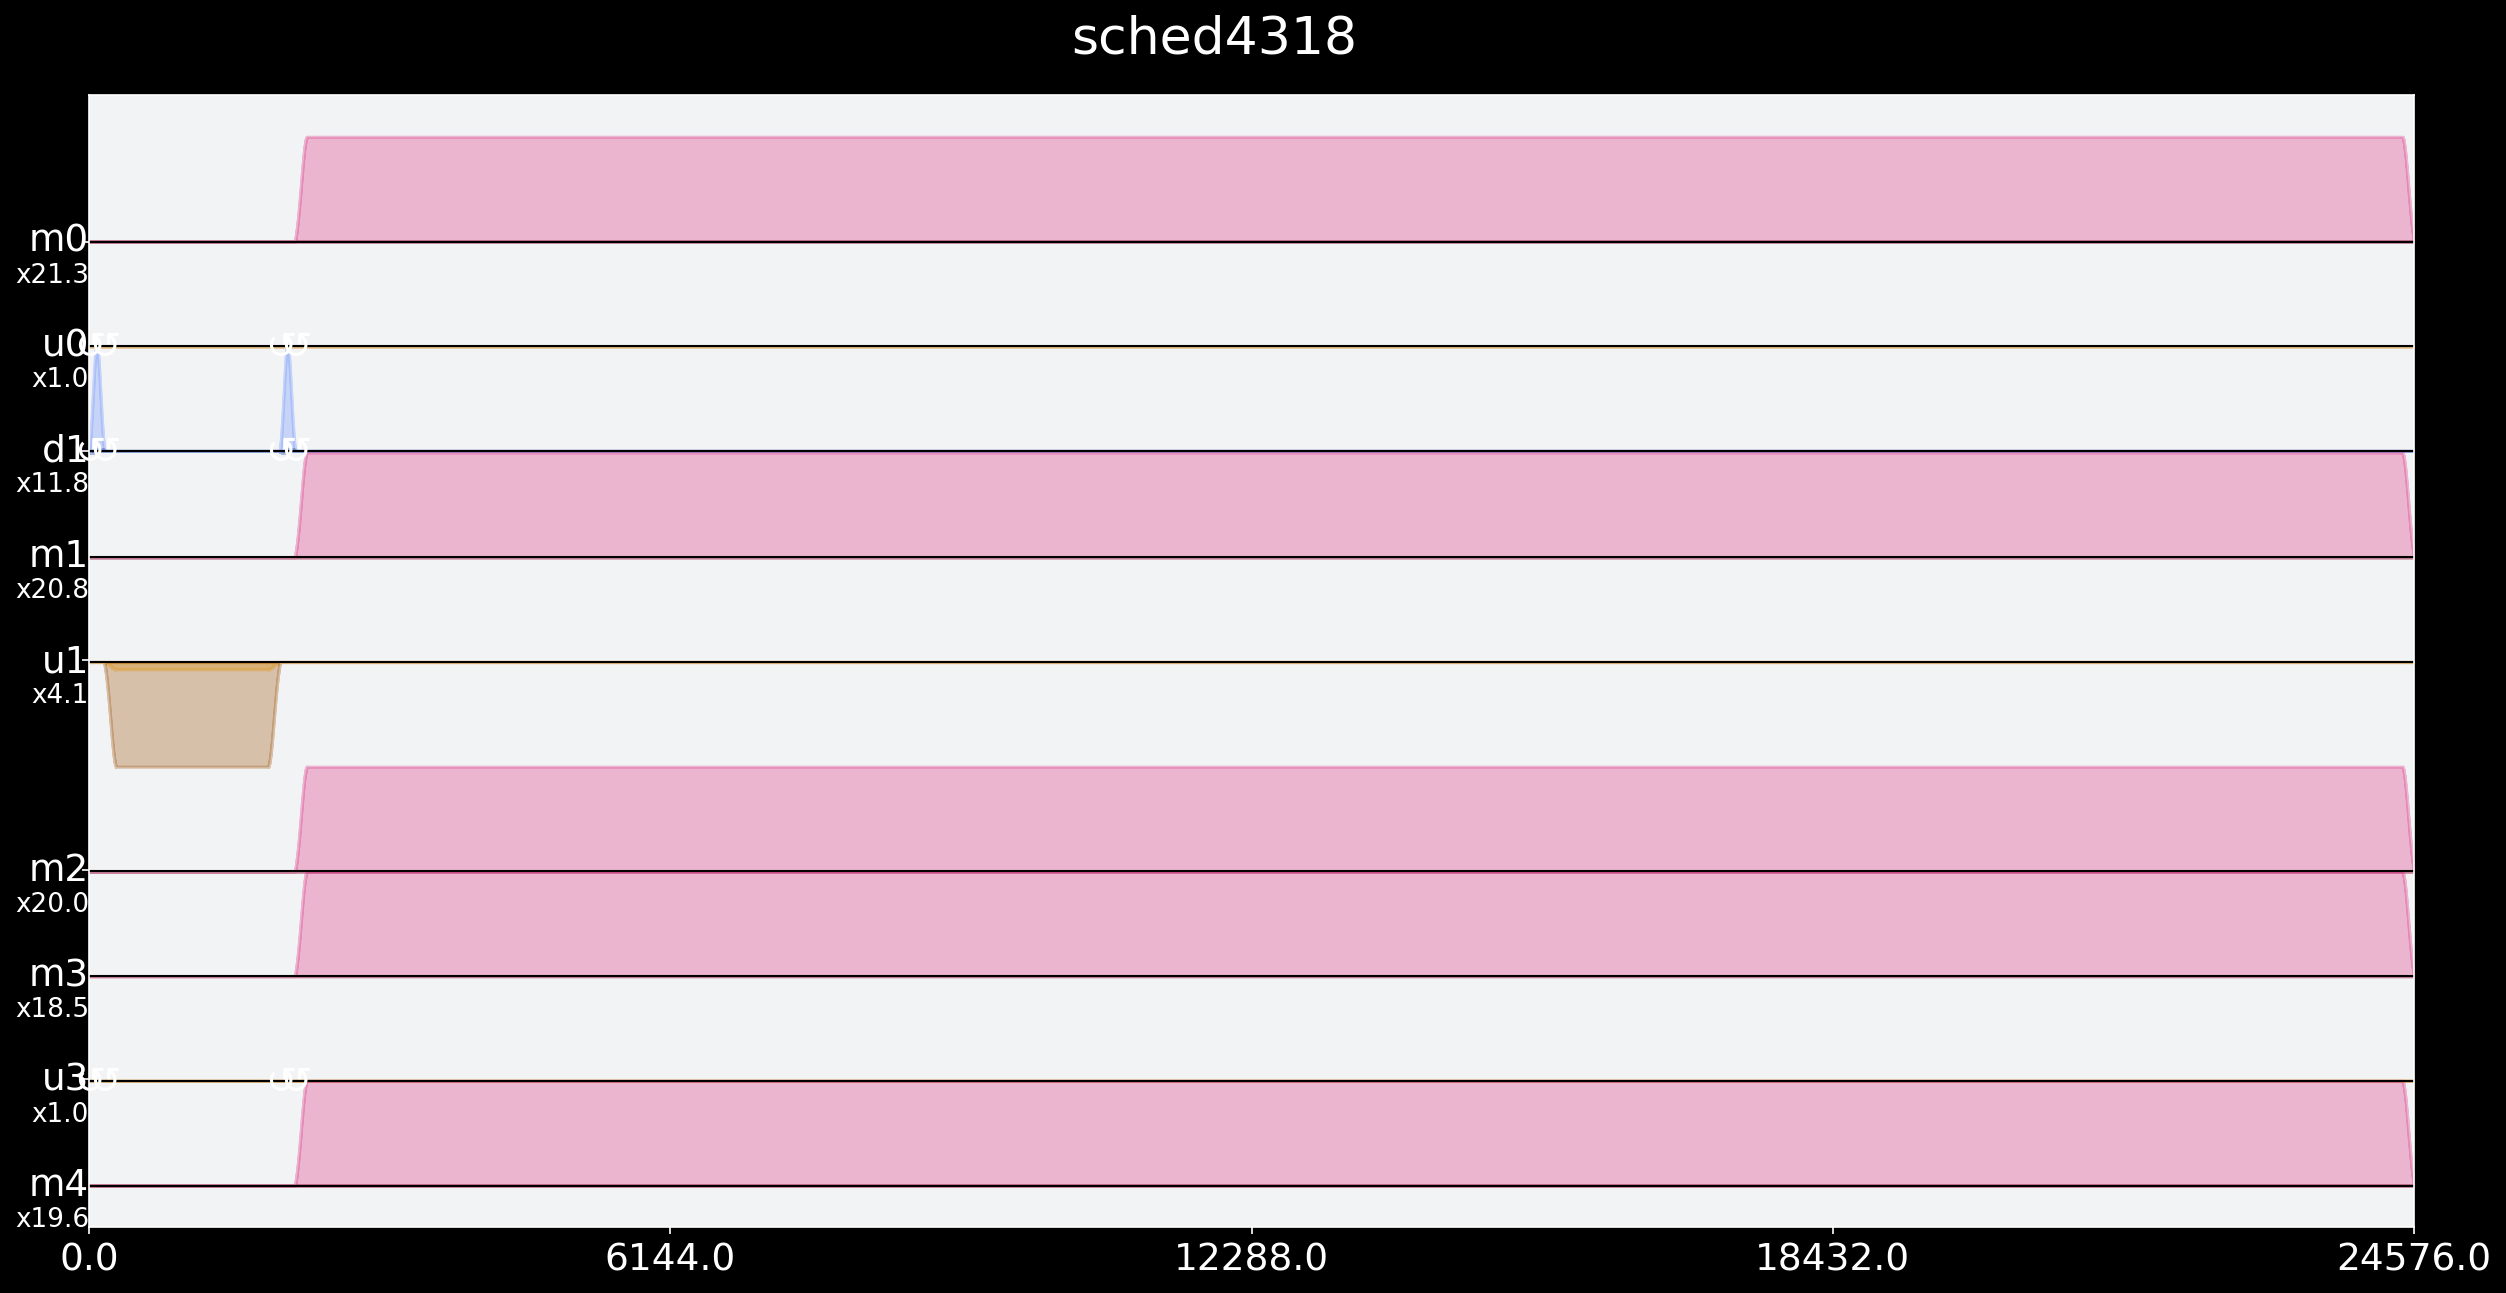

In [22]:
cr_ramsey_times = 16*np.linspace(0, 100, 21)
cr_ramsey_scheds = build_cr_ramsey_scheds(qc, qt, cr_ramsey_times)
cr_ramsey_scheds[-1].exclude(channels=[pulse.AcquireChannel(i) 
                        for i in range(backend_config.n_qubits)]).draw(style=style)

In [23]:
cr_ramsey_result = []
for sched in cr_ramsey_scheds:
    results = run_pulse(sched)
    cr_ramsey_result.append(np.real(1-2*results[qc]))

### Fitting Functions for the CR Ramsey Experiment

We will fit the results to a decaying sinusoid, where the frequency of oscillation is the frequency offset. We will also need to take care of the relation between the control and target qubit frequecies, because that will effect whether the control qubit Stark shift is higher or lower in frequency.

In [129]:
def decay_sin(t, f, a, phi, tau, offset):
    """Fit function for exponentially-decaying sinusoid."""
    return a*np.exp(-t/tau)*np.sin(2*np.pi*f*t - phi) + offset

def fit_decay_sin(ts, values, p0):
    """Perform fit of decaying sinusoid."""
    return curve_fit(decay_sin, ts, values, p0=p0)

In [62]:
def plot_cr_ramsey(cr_ramsey_times, cr_ramsey_result, ramsey_fit):
    """Plot CR Ramsey experiment and fit with ZI interaction rate."""
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    ax.scatter(cr_ramsey_times, cr_ramsey_result, lw=3.0, color='red')
    ax.plot(cr_ramsey_times, decay_sin(cr_ramsey_times, *ramsey_fit), lw=3.0, color='red')
    ax.set_ylabel('<Z(t)>', fontsize=20)
    ax.set_title('CR Ramsey Rate (ZI = %.3f MHz)' % ((ramsey_fit[0]/dt)/1e6), fontsize=20)
    ax.set_xlabel('time (dt)', fontsize=20)

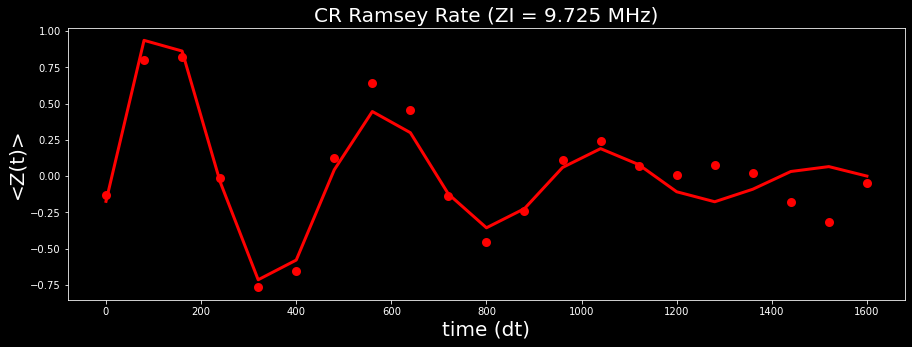

In [26]:
ramsey_fit,_ = fit_decay_sin(cr_ramsey_times, cr_ramsey_result, p0=[0.0025, 1, -np.pi/2, 300, 0.5])
plot_cr_ramsey(cr_ramsey_times, cr_ramsey_result, ramsey_fit)

In [27]:
# the sign accounts for the relation b/w control and target frequencies
ZI_rate = np.sign(oscillator_freqs[qc]-oscillator_freqs[qt])*(ramsey_fit[0]/dt)/1e6
print('Shift frame according to ZI rate of %.3f MHz' % ZI_rate)

Shift frame according to ZI rate of 9.725 MHz


Now we will rebuild the Ramsey schedule to compensate for the Stark shift and rerun the experiment.

In [110]:
# run simulation to longer times
cr_ramsey_times = 16*np.linspace(0, 250, 21)
cr_ramsey_scheds = build_cr_ramsey_scheds(qc, qt, cr_ramsey_times, ZI_MHz=ZI_rate)

cr_ramsey_result = []
for sched in cr_ramsey_scheds:
    result = run_pulse(sched)
    cr_ramsey_result.append(np.real(1-2*result[qc]))

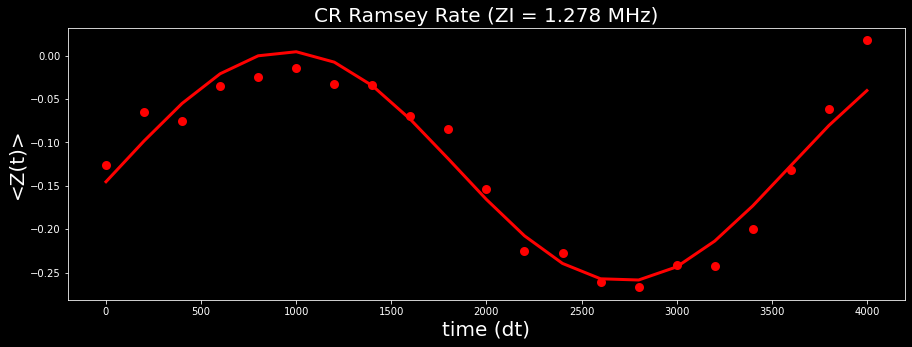

In [130]:
ramsey_fit,_ = fit_decay_sin(cr_ramsey_times, cr_ramsey_result, p0=[0.00001, 0.1, 0, 300, -0.1])
plot_cr_ramsey(cr_ramsey_times, cr_ramsey_result, ramsey_fit)

We can see that we have substantially (but not totally) reduced the frequency shift (due to higher-order levels, etc). At this point we could return to the Hamiltonian tomography experiment
```
cr_scheds = build_cr_scheds(qc, qt, cr_times, phase=phase, ZI_MHz=ZI_rate)
```
however, since the frame change only affects the control qubit, the results would be identical to the second one. 

## References <a class="anchor" id="references"></a>

[1] S Sheldon, E Magesan, JM Chow, and JM Gambetta, "Procedure for systematically tuning up crosstalk in the cross resonance gate," *Phys Rev A* **93**, 060302 (2016) <br>
[2] DC McKay, CJ Wood, S Sheldon, JM Chow, and JM Gambetta, "Efficient Z-Gates for Quantum Computing," *Phys Rev A* **96**, 022330 (2017)

In [30]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.7.0',
 'qiskit-ignis': '0.5.0',
 'qiskit-ibmq-provider': '0.11.0',
 'qiskit-aqua': '0.8.0',
 'qiskit': '0.23.0'}